Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ANOVA score for selected features :  [ 3.01764534  8.67371343 78.70347287  6.89537916 45.96764853  3.85493358]
ANOVA score for selected features :  [ 3.01764534  8.67371343 78.70347287  6.89537916 45.96764853  3.85493358]
##############


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

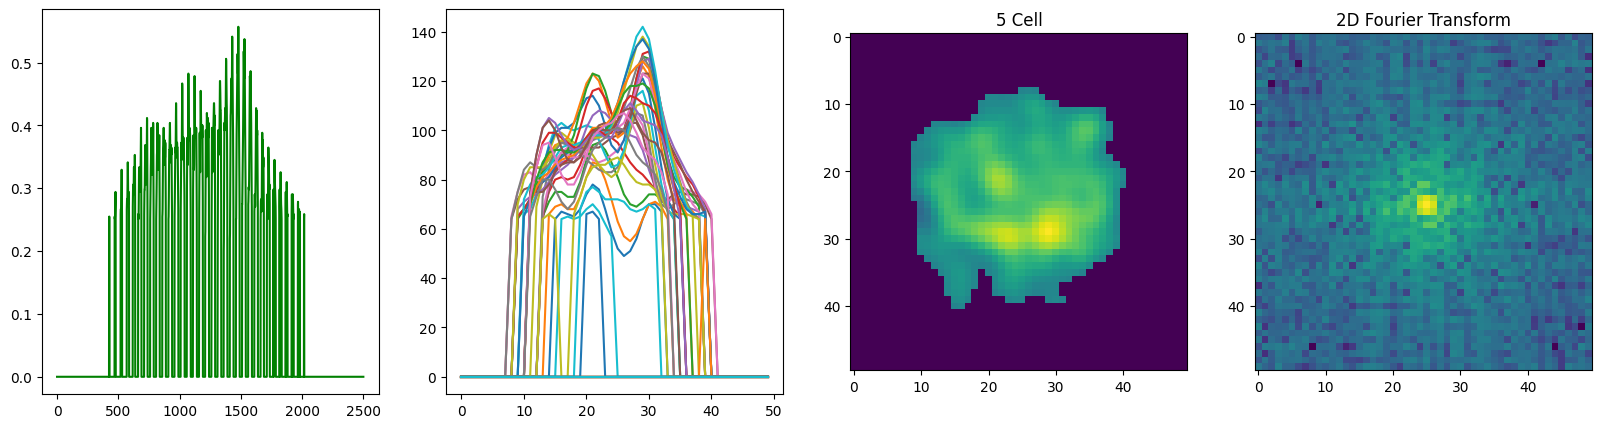

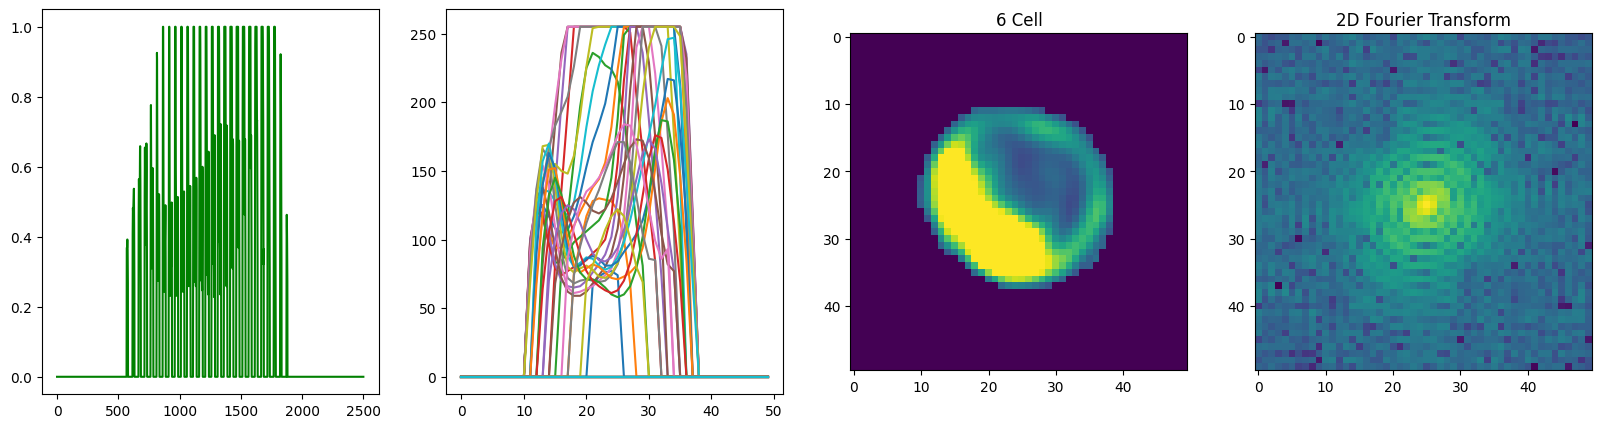

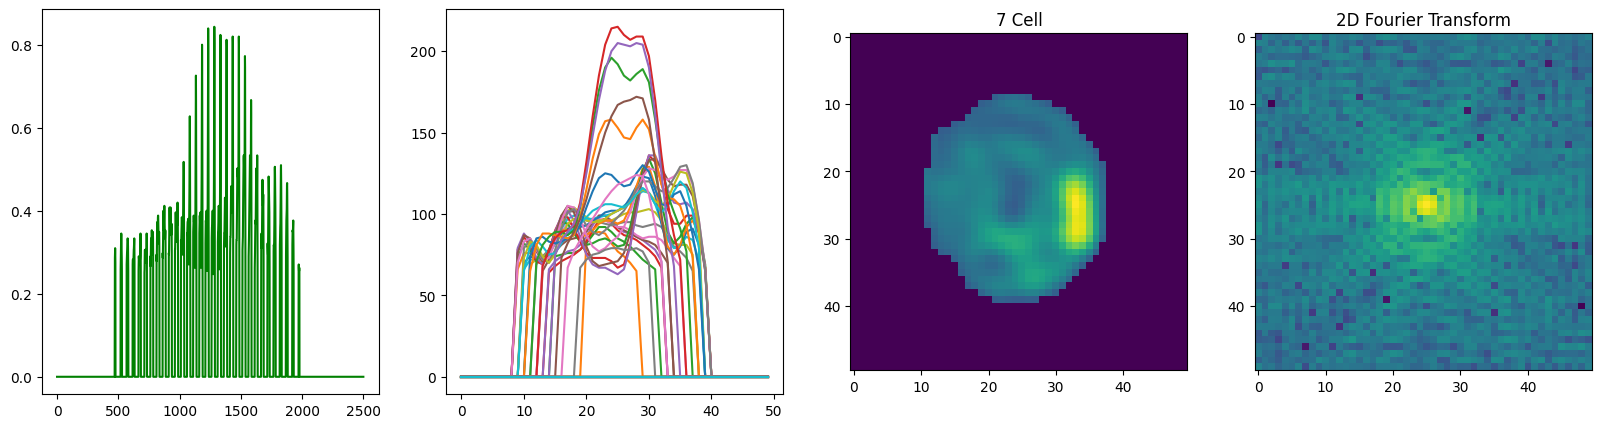

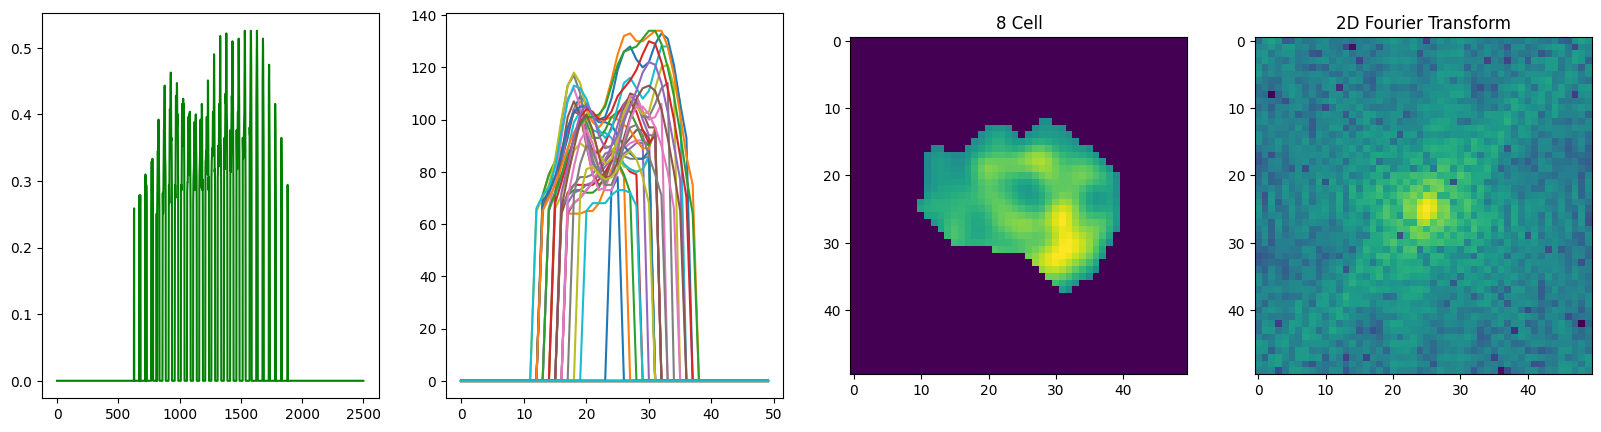

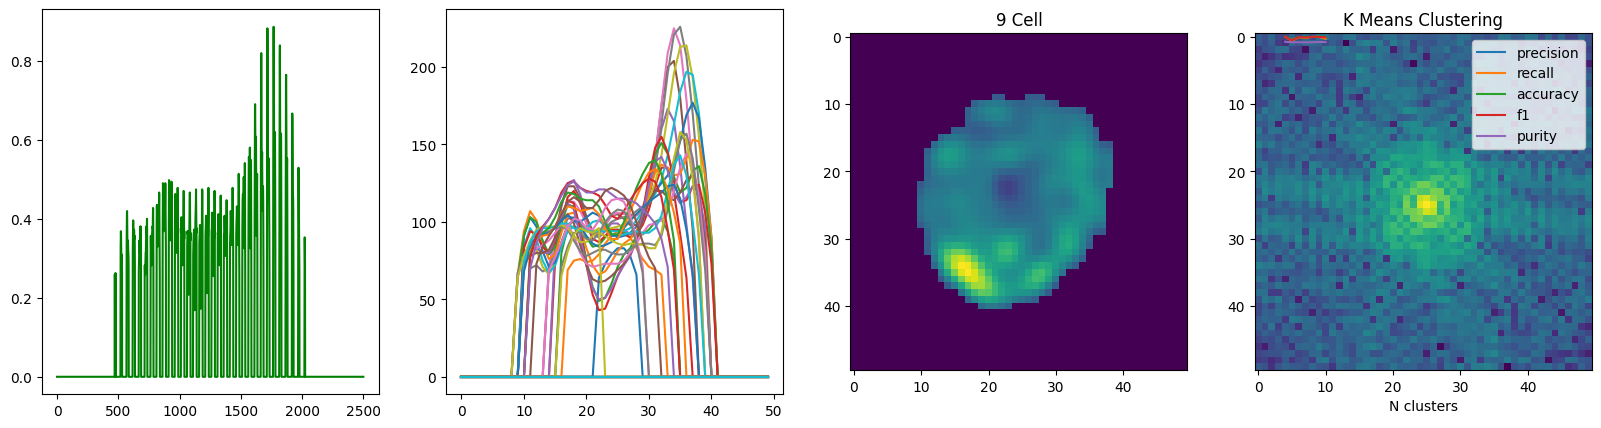

K-means: Maximum score of: 2.4948129966196277 for n = 5


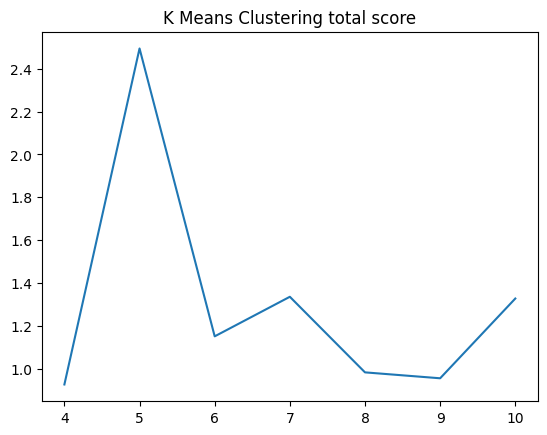

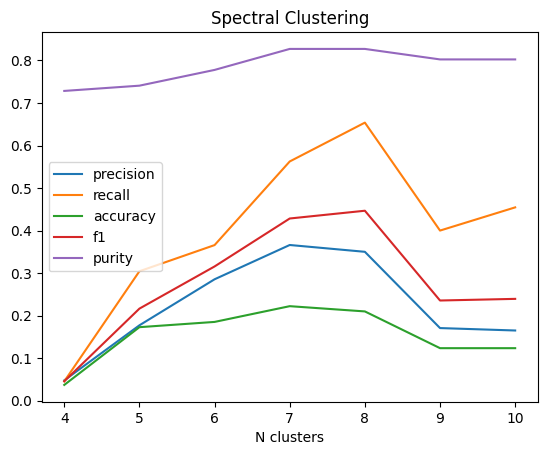

Spectral: Maximum score of: 2.4999347353251045 for n = 8


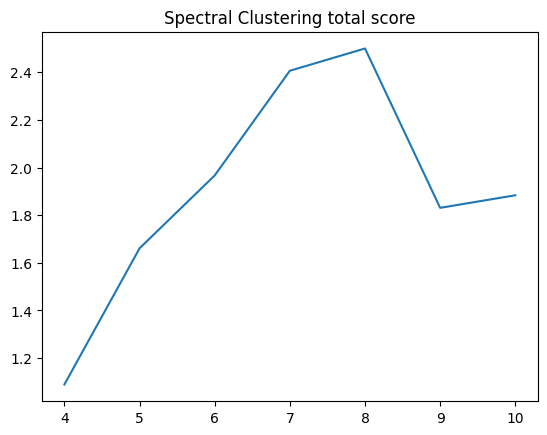

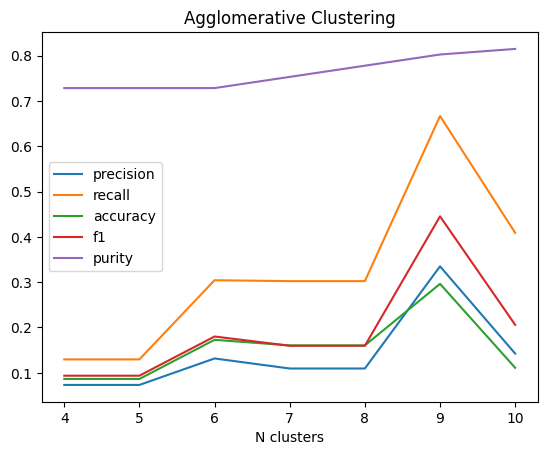

Agglomerative: Maximum score of: 2.40986579383764 for n = 9


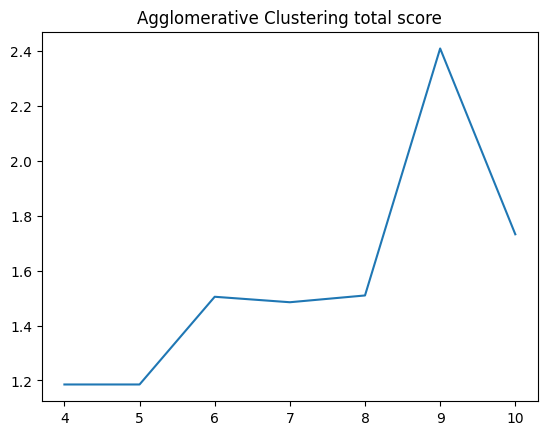

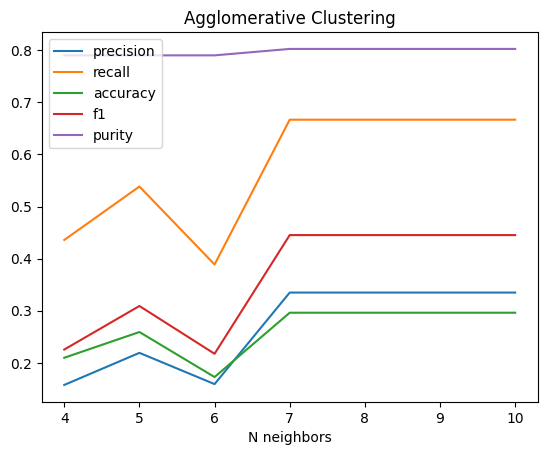

Agglomerative N-neighbors: Maximum score of: 2.545668262973442 for n = 7


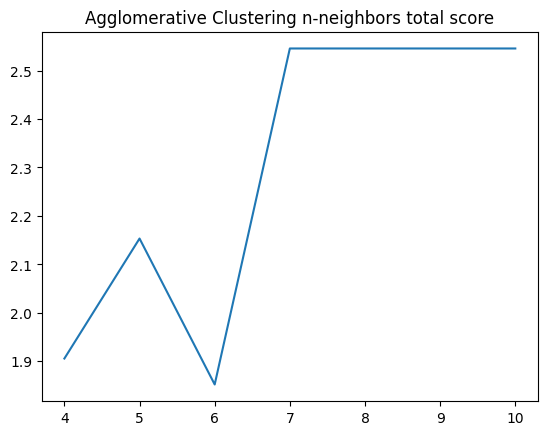

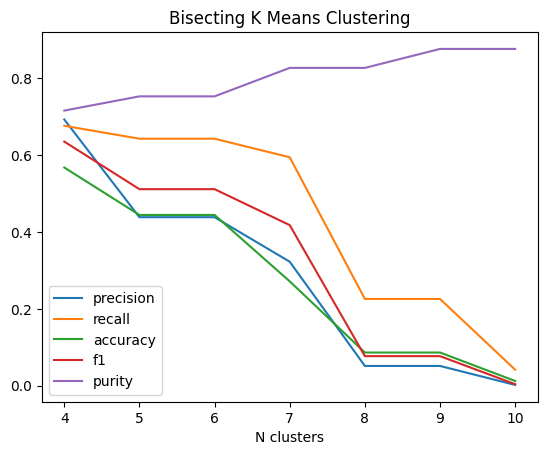

Bisecting K means: Maximum score of: 2.99236416203635 for n = 4


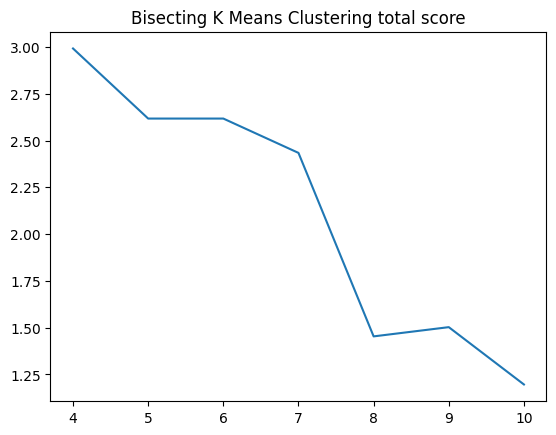

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


BisectingKmeans loss : 39.50008069984163
Purity: 0.494
Precision: 0.439
Recall: 0.643
Accuracy: 0.444
F1 Score: 0.512


In [ ]:

import numpy as np
!pip install -U scikit-learn
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imsave,imread,imshow
from sklearn.decomposition import PCA,KernelPCA
###DO IMPORT AUXLIRARY FUNCTION (for image_as_matrix)
from sklearn.manifold import Isomap
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.feature_selection import SelectKBest,chi2,f_classif,mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
import sklearn.cluster as kls
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering,KMeans,AgglomerativeClustering
from sklearn.cluster import BisectingKMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


###For extracting features used UNLABELED data -> Labeled only for comparision and verivication IMPLEMENT
###Add Labels to pandas dataframes with features like (iso1,iso2..iso6) , (pca1,pca2..pca6) IMPLEMENT
def images_as_matrix(N):
    """
    Reads all N images in the images folder (indexed 0 through N-1)
    returns a 2D numpy array with one image per row and one pixel per column
    """
    return np.array([imread(f'images/{ix}.png',as_gray=True).ravel() for ix in range(N)])/255


def report_clusters(ids, labels, report_file):
    """Generates html with cluster report
    ids is a 1D array with the id numbers of the images in the images/ folder
    labels is a 1D array with the corresponding cluster labels
    """
    diff_lbls = list(np.unique(labels))
    diff_lbls.sort()
    html = ["""<!DOCTYPE html>
    <html lang="en">
       <head>
        <meta http-equiv="content-type" content="text/html; charset=utf-8">
        <meta charset="UTF-8">
        <title>Cluster Report</title>
       </head>
       <body>
       """]
    for lbl in diff_lbls:
        html.append(f"<h1>Cluster {lbl}</h1>")
        lbl_imgs = ids[labels==lbl]
        for count,img in enumerate(lbl_imgs):
            html.append(f'<img src="images/{int(img)}.png" />')
            #if count % 10 == 9:
            #    html.append('<br/>')
    html.append("</body></html>")
    with open(report_file,'w') as ofil:
        ofil.write('\n'.join(html))

DIV_STYLE = """style = "display: block;border-style: solid; border-width: 5px;border-color:blue;padding:5px;margin:5px;" """

class feature_class:
###Loading cells images and labels
  cells_all = images_as_matrix(563)
  def splitting_cells(self):
    mat = np.loadtxt('labels.txt',delimiter=',')

    labels_train,labels_test,cells,cells_test=[],[],[],[]
    for i in range(0,563):
      if(mat[i][1]==0):
        labels_train.append(mat[i])
        cells.append(self.cells_all[i])

      else:
        labels_test.append(mat[i])
        cells_test.append(self.cells_all[i])

    cells,cells_test=np.array(cells),np.array(cells_test)
    labels_train,labels_test=np.array(labels_train),np.array(labels_test)

    phase_train,phase_test=labels_train[:,1],labels_test[:,1]

    fourier_cells=np.log(abs(np.fft.fftshift(np.fft.fft2(cells))))
    fourier_cells_test=np.log(abs(np.fft.fftshift(np.fft.fft2(cells_test))))

    #print("cells shape:",cells.shape)
    return cells,cells_test,labels_train,labels_test,fourier_cells,fourier_cells_test

  #Number= mat[:,0]
  #Label = mat[:,1]
###Extracting features and scaling them
  def features_extraction(self,cells,N_f):
    #cells = images_as_matrix(500)
    pca = PCA(n_components=N_f)
    kernel_pca = KernelPCA(n_components=N_f,kernel='rbf')
    iso = Isomap(n_components=N_f)
    kernel_pca.fit(cells)
    pca.fit(cells)
    iso.fit(cells)

    scaler_pca = MinMaxScaler()
    scaler_kernel = MinMaxScaler()
    scaler_iso = MinMaxScaler()

    features_pca =pd.DataFrame(scaler_pca.fit_transform(pca.fit_transform(cells)))
    features_kernel =pd.DataFrame(scaler_kernel.fit_transform (kernel_pca.fit_transform(cells)))
    features_iso =pd.DataFrame(scaler_iso.fit_transform (iso.fit_transform(cells)))
    features_all = pd.concat([features_pca,features_kernel,features_iso],axis=1)
    #print("Features shape",features_all.shape)
    return features_all

  #Features_pca,Features_kernel,Features_iso=features_extraction(6)

###Plotting corellation function
  def plotting_corellation(self,features):
    features = pd.DataFrame(features)
    column_headers = list(features.columns.values)
    #print("The Column Header :", column_headers)
    plt.figure(2)
    features.plot(kind='box')
    plt.figure(3)
    features.hist(alpha=0.5, bins=15)
    plt.figure(4)
    pd.plotting.scatter_matrix(features, alpha=0.5, figsize=(15,10), diagonal='kde')
    plt.figure(5)
    one_class = features[ column_headers ]
    one_class['Name'] = 'all'

    pd.plotting.parallel_coordinates(one_class, 'Name')
    plt.figure(6)
    pd.plotting.radviz(one_class,'Name')



###Selcting most informative features
  def feature_select(self,features_test,labels_test,features_train,Kbest=10,n_features_select=6):
    #f_anova,prob_anova = f_classif(features_test,labels_test)
    #print(f"ANOVA score for all features : ",f_anova)
    #mutual=mutual_info_classif(features_test,labels_test, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    anova=SelectKBest(f_classif, k=Kbest).fit(features_test,labels_test)
    features_anova_test=anova.transform(features_test)
    features_anova_train = anova.transform(features_train)

    KNN = KNeighborsClassifier(n_neighbors=3)
    SFS = SequentialFeatureSelector(KNN, n_features_to_select=n_features_select, direction="backward")
    SFS.fit(features_anova_test,labels_test)
    features_selected = SFS.transform(features_anova_train)
    features_selected_test=SFS.transform(features_anova_test)
    f_anova,prob_anova = f_classif(features_selected_test,labels_test)
    print(f"ANOVA score for selected features : ",f_anova)
    return features_selected

###Fancy visualisation of the loaded data


  def visualisation(self,N_start,N_end):
    cells1 =[]
    for i in range(N_start,N_end):
      cell1 = imread(f"images/{i}.png")
      w,h = cell1.shape
      cols = np.reshape(cell1/255.0, (w * h))

      plt.figure(i,figsize=(20, 5))
      plt.subplot(1, 4, 1)
      plt.plot(cols,c='g')
      plt.subplot(1, 4, 2)
      plt.plot(cell1)
      plt.subplot(1, 4, 3)
      plt.imshow(cell1,interpolation='nearest')
      plt.title(f'{i} Cell')
      plt.subplot(1, 4, 4)
      plt.imshow(np.log(abs(np.fft.fftshift(np.fft.fft2(cell1)))))
      plt.title(f'2D Fourier Transform')
      cells1.append(cols)

  def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    purity=np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    print("Purity:",purity)
    return purity


  def own_clustering(self,features_train,features_test,labels_test,n_neighbors=10,n_cluster_kmeans=5,n_cluster_spectral=8,n_cluster_agglo=9):
    #kmeans clustering

    kmeans=KMeans(n_clusters=n_cluster_kmeans)
    label_train_kmeans=kmeans.fit_predict(features_train)
    label_test_kmeans=kmeans.predict(features_test)

    #score_kmeans=self.external_scores(label_test_kmeans,labels_test)

    #spectral clustering
    ###Different assign_labels 'cluster_qt'
    spectral = SpectralClustering(n_clusters=n_cluster_spectral,assign_labels="cluster_qr",random_state=0)
    label_train_spectral=spectral.fit_predict(features_train)
    label_test_spectral=spectral.fit_predict(features_test)
    #score_spectral=self.external_scores(label_test_spectral,labels_test)

    #agglomerative clustering
    connectivityTrain = kneighbors_graph(features_train,n_neighbors=n_neighbors,include_self=False)
    connectivityTest = kneighbors_graph(features_test,n_neighbors=n_neighbors,include_self=False)
    agglo=AgglomerativeClustering(n_clusters=n_cluster_agglo,connectivity=connectivityTrain)
    aggloTest=AgglomerativeClustering(n_clusters=n_cluster_agglo,connectivity=connectivityTest)
    ###DONT USE WARD CUZ ITS FOR THE EUCALIDIAN DISTANCE
    label_train_agglo=agglo.fit_predict(features_train)
    label_test_agglo=aggloTest.fit_predict(features_test)
    #score_agglo=self.external_scores(label_test_agglo,labels_test)
    return label_train_kmeans,label_train_spectral,label_train_agglo

  def another_clustering(self,features_train,features_test,labels_test,n_clusters=5):
    bisect_means = BisectingKMeans(n_clusters=n_clusters, random_state=0)
    label_train_bi=bisect_means.fit_predict(features_train)
    label_test_bi=bisect_means.predict(features_test)
    bi_loss=bisect_means.inertia_
    print("BisectingKmeans loss :",bi_loss)
    score_bi=self.external_scores(label_test_bi,labels_test)
    return label_train_bi



    print("Another clustering")

  def WIZ_html(self,label_kmeans,label_spectral,label_agglo,labels_train):
    report_clusters(labels_train,label_kmeans,f"kmeans_6c.html")
    report_clusters(labels_train,label_spectral,f"spectral_8c_10n.html")
    report_clusters(labels_train,label_agglo,f"agglo_9c.html")

  def external_scores(self,y_test,y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_test, y_pred)
    purity=np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    print('Purity: %.3f' % purity)
    print('Precision: %.3f' % precision_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred)))
    print('Recall: %.3f' % recall_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred)))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred)))

    #print("Welcome")
  def score_all(self,_features_train,_features_test, _labels_test, n_neighbors=10):
      print("##############")
      bestNarr = np.array([])
      for y in range(1,6):
          precision_arr = np.array([])
          recall_arr = np.array([])
          accuracy_arr = np.array([])
          f1_arr = np.array([])
          purity_arr = np.array([])
          for x in range(4,11):
              if y==1:
                  kmeans=KMeans(n_clusters=x)
                  label_train_out=kmeans.fit_predict(_features_train)
                  label_test_out=kmeans.predict(_features_test)
                  plt.xlabel("N clusters")
                  plt.title("K Means Clustering")
              elif y==2:
                  spectral = SpectralClustering(n_clusters=x,assign_labels="cluster_qr",random_state=0)
                  label_train_out=spectral.fit_predict(_features_train)
                  label_test_out=spectral.fit_predict(_features_test)
                  plt.xlabel("N clusters")
                  plt.title("Spectral Clustering")
              elif y==3:
                  connectivityTrain = kneighbors_graph(_features_train,n_neighbors=n_neighbors,include_self=False)
                  connectivityTest = kneighbors_graph(_features_test,n_neighbors=n_neighbors,include_self=False)
                  agglo=AgglomerativeClustering(n_clusters=x,connectivity=connectivityTrain)
                  aggloTest=AgglomerativeClustering(n_clusters=x,connectivity=connectivityTest)
                  label_train_out=agglo.fit_predict(features_train)
                  label_test_out=aggloTest.fit_predict(features_test)
                  plt.xlabel("N clusters")
                  plt.title("Agglomerative Clustering")
              elif y==4:
                  connectivityTrain = kneighbors_graph(_features_train,n_neighbors=x,include_self=False)
                  connectivityTest = kneighbors_graph(_features_test,n_neighbors=x,include_self=False)
                  agglo=AgglomerativeClustering(n_clusters=9,connectivity=connectivityTrain)
                  aggloTest=AgglomerativeClustering(n_clusters=9,connectivity=connectivityTest)
                  label_train_out=agglo.fit_predict(features_train)
                  label_test_out=aggloTest.fit_predict(features_test)
                  plt.xlabel("N neighbors")
                  plt.title("Agglomerative Clustering")
              elif y==5:
                  bisect_means = kls.BisectingKMeans(n_clusters=x, random_state=0)
                  label_train_out=bisect_means.fit_predict(_features_train)
                  label_test_out=bisect_means.predict(_features_test)
                  #bi_loss=bisect_means.inertia_
                  #print("BisectingKmeans loss :",bi_loss)
                  plt.xlabel("N clusters")
                  plt.title("Bisecting K Means Clustering")
              contingency_matrix = metrics.cluster.contingency_matrix(_labels_test, label_test_out)
              purity=np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
              precision_arr = np.append(precision_arr, precision_score(label_test_out, _labels_test,average='weighted',labels=np.unique(_labels_test)))
              recall_arr = np.append(recall_arr, recall_score(label_test_out, _labels_test,average='weighted',labels=np.unique(_labels_test)))
              accuracy_arr = np.append(accuracy_arr, accuracy_score(label_test_out, _labels_test))
              f1_arr = np.append(f1_arr, f1_score(label_test_out, _labels_test,average='weighted',labels=np.unique(_labels_test)))
              purity_arr = np.append(purity_arr, purity)
          plt.plot(range(4,11),precision_arr)
          plt.plot(range(4,11),recall_arr)
          plt.plot(range(4,11),accuracy_arr)
          plt.plot(range(4,11),f1_arr)
          plt.plot(range(4,11),purity_arr)
          plt.legend(["precision", "recall", "accuracy", "f1", "purity"])
          plt.show()
          scoreArr = np.array([])
          maxScore=0
          bestN = 0
          for x in range(4,11):
              sumScore = precision_arr[x-4]+recall_arr[x-4]+accuracy_arr[-4]+f1_arr[x-4]+purity_arr[x-4]
              scoreArr = np.append(scoreArr, sumScore)
              if sumScore>maxScore:
                  maxScore=sumScore
                  bestN = x
          if y==1:
              plt.title("K Means Clustering total score")
              print("K-means: Maximum score of:",maxScore,"for n =",bestN)
          elif y==2:
              plt.title("Spectral Clustering total score")
              print("Spectral: Maximum score of:",maxScore,"for n =",bestN)
          elif y==3:
              plt.title("Agglomerative Clustering total score")
              print("Agglomerative: Maximum score of:",maxScore,"for n =",bestN)
          elif y==4:
              plt.title("Agglomerative Clustering n-neighbors total score")
              print("Agglomerative N-neighbors: Maximum score of:",maxScore,"for n =",bestN)
          elif y==5:
              plt.title("Bisecting K Means Clustering total score")
              print("Bisecting K means: Maximum score of:",maxScore,"for n =",bestN)
          plt.plot(range(4,11),scoreArr)
          plt.show()
          bestNarr = np.append(bestNarr, bestN)
      return int(bestNarr[0]), int(bestNarr[1]), int(bestNarr[2]), int(bestNarr[3]), int(bestNarr[4])



FC = feature_class()
cells_train,cells_test,labels_train,labels_test,fourier_cells_train,fourier_cells_test=FC.splitting_cells()
features_test,features_train=FC.features_extraction(cells_test,6),FC.features_extraction(cells_train,6)
FC.visualisation(5,10)


#Select number of features to be picked anova first argument , wrapper second
features_selected=FC.feature_select(features_test,labels_test[:,1],features_train,10,6)
features_selected_test=FC.feature_select(features_test,labels_test[:,1],features_test,10,6)

#FC.plotting_corellation(features_selected)

#first argument neighbors ,second clusters

kMeanN, spectralN, aggloNclusters, aggloNneighbors, bisectingNclusters = FC.score_all(features_selected,features_selected_test,labels_test[:,1])

###For automatic clusters/neigbors number pick uncomment next line and comment the one after it
#label_kmeans,label_spectral,label_agglo=FC.own_clustering(features_selected,features_selected_test,labels_test[:,1],aggloNneighbors,kMeanN, spectralN, aggloNclusters)
label_kmeans,label_spectral,label_agglo=FC.own_clustering(features_selected,features_selected_test,labels_test[:,1],10,6,8,9)


#label_kmeans,label_spectral,label_agglo=FC.own_clustering(features_train,features_test,labels_test[:,1],10)

a=np.array(labels_train[:,0])
FC.WIZ_html( label_kmeans ,label_spectral, label_agglo, a)

#FC.plotting_corellation(pd.DataFrame(features_selected))

label_bi=FC.another_clustering(features_selected,features_selected_test,labels_test[:,1],6)
report_clusters(a,label_bi,f"bi_6c.html")


###https://neptune.ai/blog/feature-selection-methods -Feature selection
###https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/ - External scores
###https://stackoverflow.com/questions/34047540/python-clustering-purity-metric -Purity
###https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b -Fourier

#FC.feature_selection(features_train)




<Figure size 640x480 with 0 Axes>

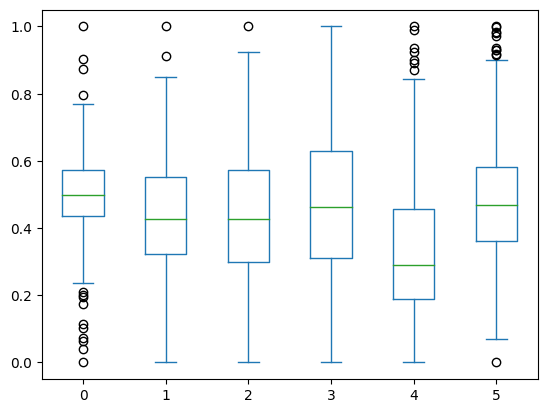

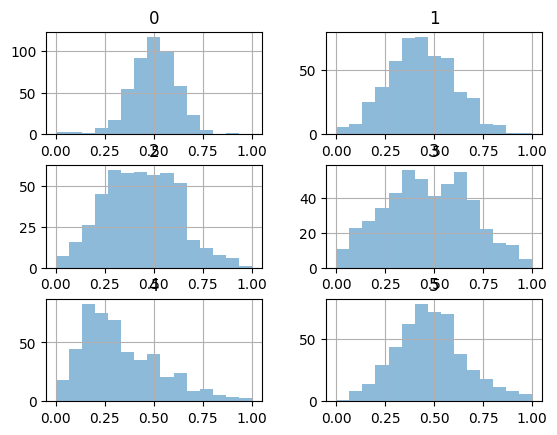

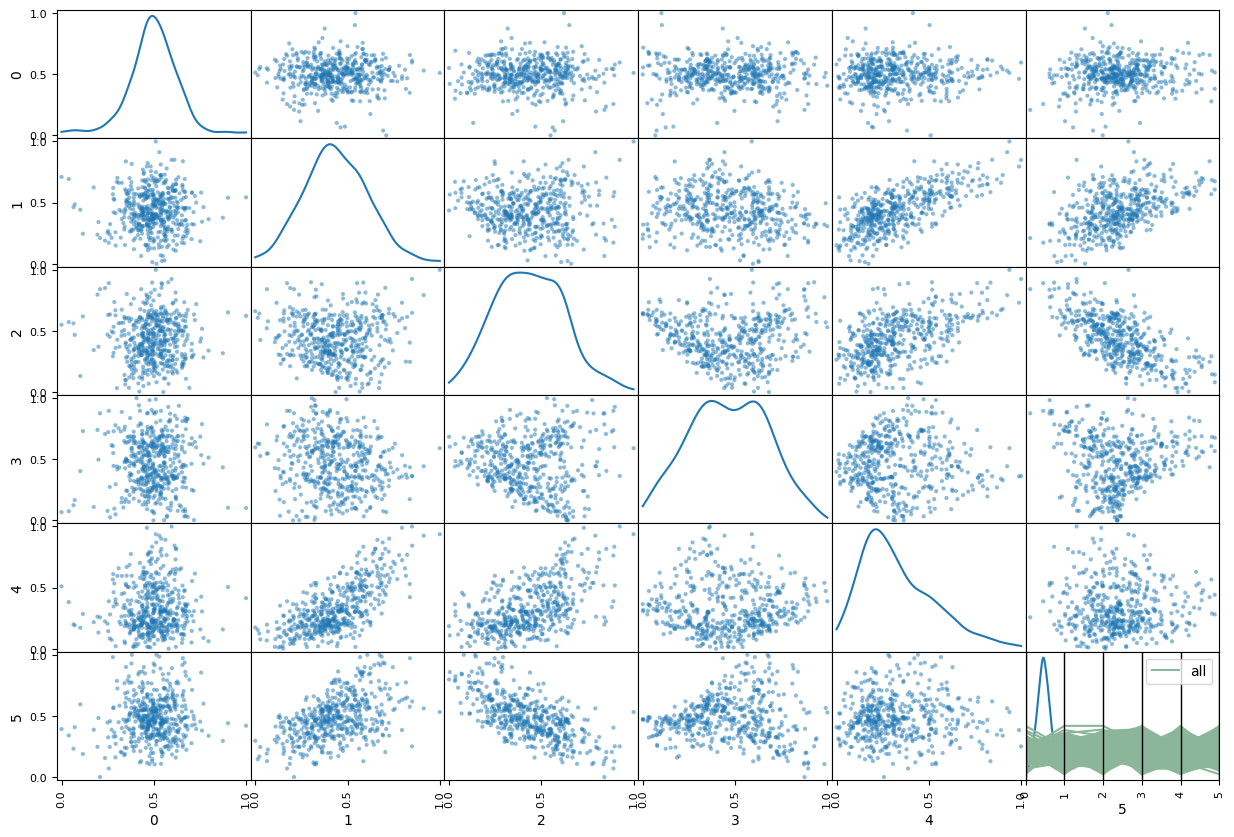

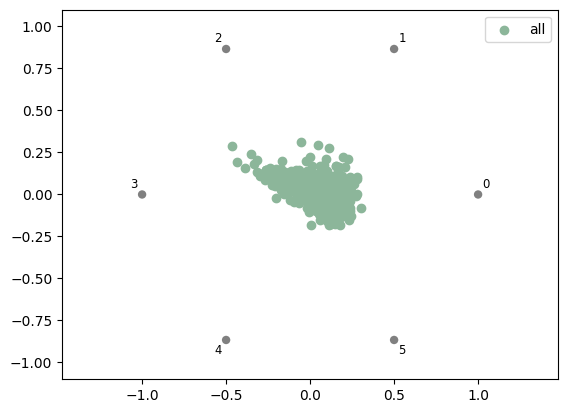

In [ ]:
FC.plotting_corellation(features_selected)

[0.27315222 0.1095669  0.07690695 0.05055711 0.04690517 0.03422526
 0.0316024  0.02947653 0.02815763 0.02408655 0.01813091 0.01277498
 0.01118371 0.01093077 0.0104913  0.01021522]
(500, 16)
The Column Header : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<ipython-input-5-9c8c8734c716>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_class['Name'] = 'all'


<Axes: >

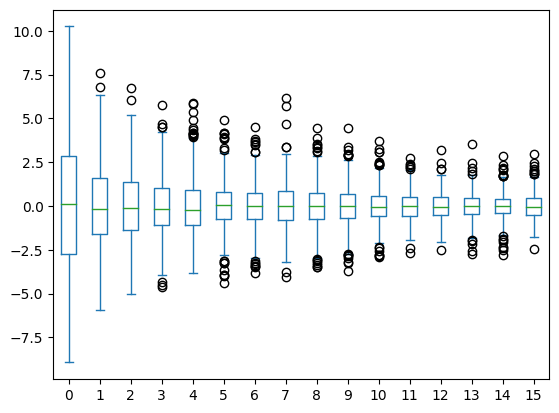

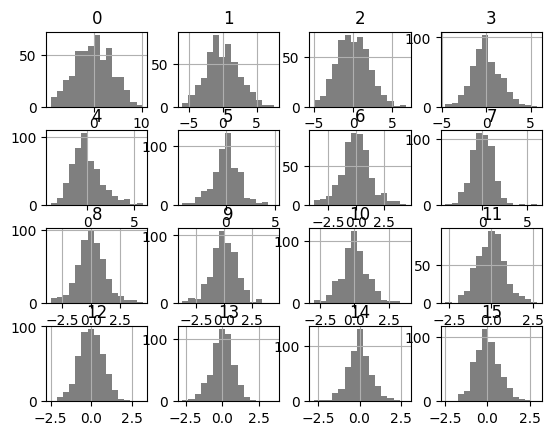

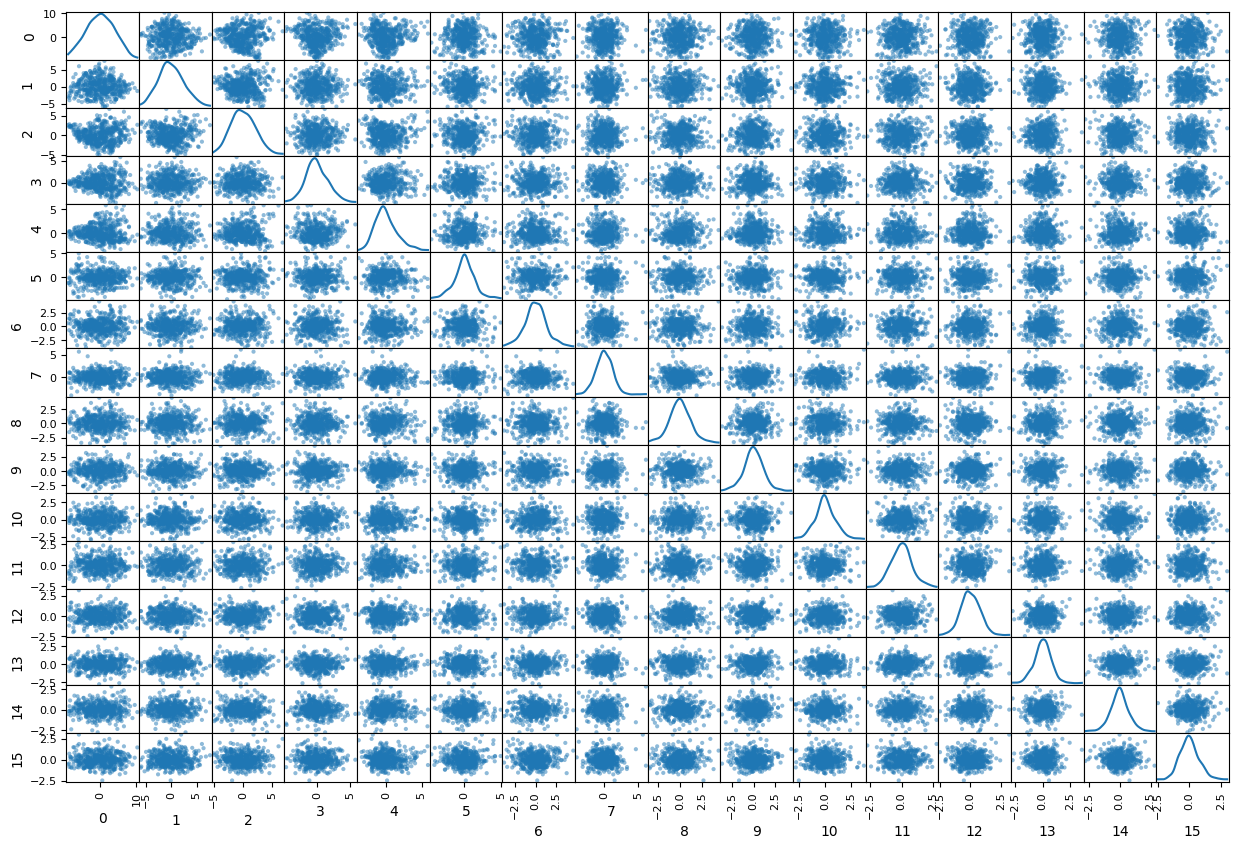

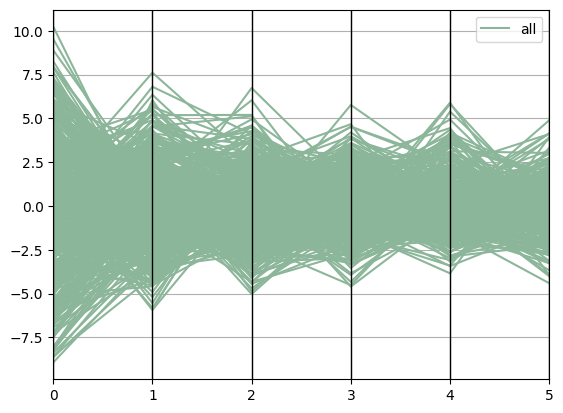

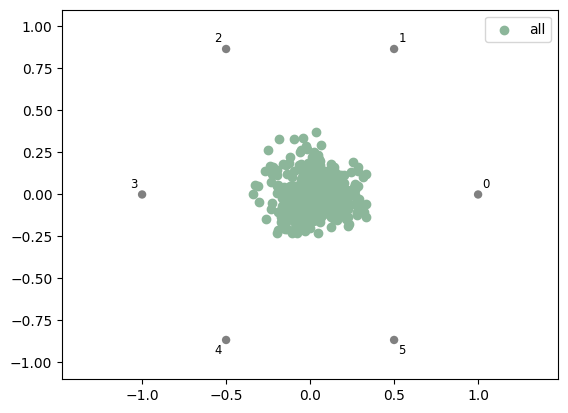

In [ ]:
from sklearn.decomposition import PCA

###For extracting features used unlabeled data  IMPLEMENT
###Add Labels to pandas dataframes with features like (iso1,iso2..iso6) , (pca1,pca2..pca6)
def features_ext(self,cells,N_f):
    #cells = images_as_matrix(500)
    pca = PCA(n_components=N_f)
    kernel_pca = KernelPCA(n_components=N_f,kernel='rbf')
    iso = Isomap(n_components=N_f)
    kernel_pca.fit(cells)
    pca.fit(cells)
    iso.fit(cells)

    scaler_pca = MinMaxScaler()
    scaler_kernel = MinMaxScaler()
    scaler_iso = MinMaxScaler()

    features_pca =pd.DataFrame(scaler_pca.fit_transform(pca.fit_transform(cells)))
    features_kernel =pd.DataFrame(scaler_kernel.fit_transform (kernel_pca.fit_transform(cells)))
    features_iso =pd.DataFrame(scaler_iso.fit_transform (iso.fit_transform(cells)))
    features_all = pd.concat([features_pca,features_kernel,features_iso],axis=1)
    #print("Features shape",features_all.shape)
    return features_all

cells=[]
cells = images_as_matrix(500)
pca = PCA(n_components=6)
pca.fit(cells)
print(pca.explained_variance_ratio_)
data_pca = pca.transform(cells)
print(data_pca.shape)
#for i in range(t_data.shape[1]):
  #plt.figure(i)
  #plt.hist(t_data[i], alpha=0.5, bins=8)
import pandas as pd

data_pca = pd.DataFrame(data_pca)
column_headers = list(data_pca.columns.values)
print("The Column Header :", column_headers)
data_pca.plot(kind='box')
data_pca.hist(color='k', alpha=0.5, bins=15)
pd.plotting.scatter_matrix(data_pca, alpha=0.5, figsize=(15,10), diagonal='kde')
one_class = data_pca[ [0, 1, 2, 3, 4, 5] ]
one_class['Name'] = 'all'
plt.figure(5)
pd.plotting.parallel_coordinates(one_class, 'Name')

#pd.plotting.parallel_coordinates(data_pca,'Name')
#pd.plotting.parallel_coordinates(data_pca, class_column='element', cols=['var 1', 'var 2', 'var 3','var 4', 'var 5', 'var 6'])
plt.figure(6)
pd.plotting.radviz(one_class,'Name')
